In [1]:
import numpy as np
np.random.seed(42)
import sys
import cProfile
import h5py
sys.path.insert(0, '../..')
%reload_ext memory_profiler
%reload_ext autoreload
%autoreload 1
import allel; print(allel.__version__)
%aimport allel.stats.selection

0.21.0.dev0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
callset = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.3R.h5',
                    mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.haplotypes.3R.h5" (mode r)>

In [4]:
n_variants = 1000000
n_samples = 50

In [5]:
h1 = allel.GenotypeArray(callset['3R']['calldata/genotype'][:n_variants, :n_samples]).to_haplotypes()
h1

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [6]:
h2 = allel.GenotypeArray(callset['3R']['calldata/genotype'][:n_variants, -n_samples:]).to_haplotypes()
h2

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [7]:
pos = callset['3R']['variants/POS'][:n_variants]
pos

array([   1252,    1262,    1271, ..., 3808745, 3808748, 3808749], dtype=int32)

In [8]:
ac1 = h1.count_alleles(max_allele=1)
ac2 = h2.count_alleles(max_allele=1)
ac = allel.AlleleCountsArray(ac1 + ac2)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 1)
h1_seg = h1.compress(is_seg, axis=0)
h2_seg = h2.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
ac1_seg = ac1.compress(is_seg, axis=0)
ac2_seg = ac2.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

206253

In [9]:
%%time
score = allel.stats.xpnsl(h1_seg, h2_seg, use_threads=False)

CPU times: user 5.57 s, sys: 4 ms, total: 5.58 s
Wall time: 5.57 s


In [10]:
%%time
score_threaded = allel.stats.xpnsl(h1_seg, h2_seg, use_threads=True)

CPU times: user 6.19 s, sys: 8 ms, total: 6.2 s
Wall time: 1.61 s


In [11]:
score

array([-0.96187103, -0.9148735 , -0.94841577, ..., -0.16637026,
       -0.17471978, -0.1129918 ])

In [12]:
score_threaded

array([-0.96187103, -0.9148735 , -0.94841577, ..., -0.16637026,
       -0.17471978, -0.1129918 ])

In [14]:
np.count_nonzero(np.isnan(score)), np.count_nonzero(~np.isnan(score))

(0, 206253)

In [15]:
np.count_nonzero(np.isinf(score)), np.count_nonzero(~np.isinf(score))

(0, 206253)

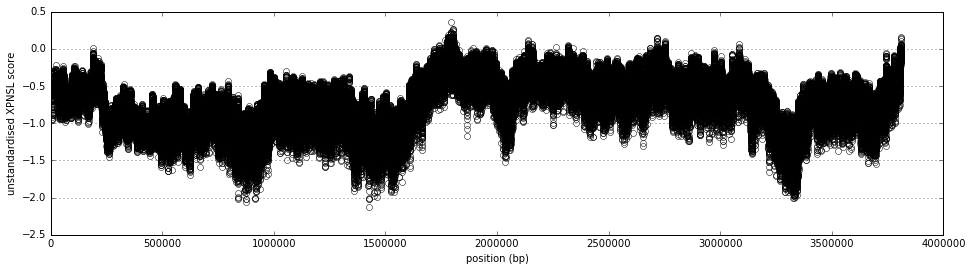

In [16]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised XPNSL score');

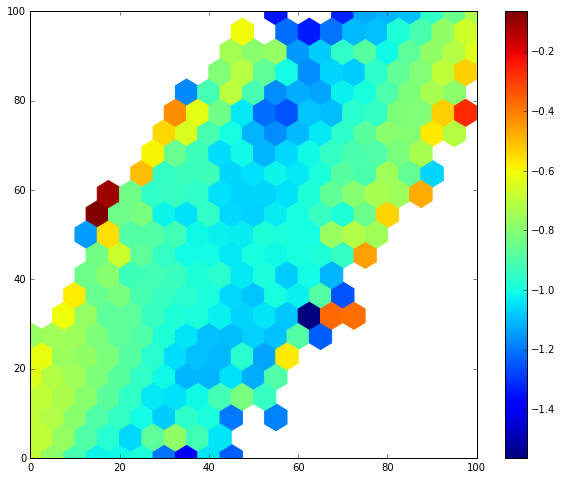

In [17]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
C = score
plt.figure(figsize=(10, 8))
plt.hexbin(x, y, C, gridsize=20)
plt.colorbar();

In [18]:
import scipy as sp
import scipy.stats

In [19]:
bins = np.arange(0, n_samples*2 + 1, 10)
mean_by_aac, _, _, _ = sp.stats.binned_statistic_2d(ac1_seg[:, 1], ac2_seg[:, 1], score, 
                                                                  statistic=np.nanmean, bins=bins)
std_by_aac, _, _, _ = sp.stats.binned_statistic_2d(ac1_seg[:, 1], ac2_seg[:, 1], score, 
                                                                statistic=np.nanstd, bins=bins)

In [20]:
hst, _, _ = np.histogram2d(ac1_seg[:, 1], ac2_seg[:, 1], bins=bins)

In [21]:
hst[-1, -1]

3178.0

In [22]:
hst[0, -1]

0.0

In [23]:
mean_by_aac[2, -1]

nan

In [24]:
bins

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [25]:
mean_by_aac.shape

(10, 10)

In [26]:
mean_by_aac.shape, std_by_aac.shape

((10, 10), (10, 10))

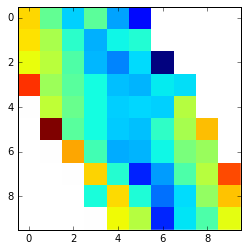

In [27]:
plt.imshow(mean_by_aac.T, interpolation='none');

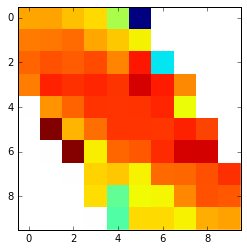

In [28]:
plt.imshow(std_by_aac.T, interpolation='none');

In [29]:
score_centred = np.zeros_like(score)
score_normed = np.zeros_like(score)

In [30]:
bins

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [31]:
score.shape

(206253,)

In [32]:
score_centred.shape

(206253,)

In [33]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
for i in range(len(bins) - 1):
    for j in range(len(bins) - 1):
        x1 = bins[i]
        x2 = bins[i + 1]
        y1 = bins[j]
        y2 = bins[j + 1]
        if i+1 == len(bins) - 1:
            locx = (x >= x1) & (x <= x2)
        else:
            locx = (x >= x1) & (x < x2)
        if j+1 == len(bins) - 1:
            locy = (y >= y1) & (y <= y2)
        else:
            locy = (y >= y1) & (y < y2)
        loc = locx & locy
        if np.count_nonzero(loc):
            m = mean_by_aac[i, j]
            s = std_by_aac[i, j]
            print(i, j, x1, x2, y1, y2, np.count_nonzero(loc), m, s)
            score_centred[loc] = score[loc] - m
            score_normed[loc] = score_centred[loc] / s

0 0 0 10 0 10 152560 -0.710867465073 0.309673028295
0 1 0 10 10 20 7120 -0.718605130945 0.329675768725
0 2 0 10 20 30 450 -0.751805457778 0.339006496755
0 3 0 10 30 40 40 -0.556818136318 0.328259728803
1 0 10 20 0 10 5915 -0.893925281745 0.311762662722
1 1 10 20 10 20 7955 -0.819150275846 0.331287171359
1 2 10 20 20 30 2554 -0.802518189524 0.346691492093
1 3 10 20 30 40 463 -0.832737127644 0.369577475782
1 4 10 20 40 50 70 -0.795534601552 0.317084923747
1 5 10 20 50 60 7 -0.432224377379 0.422484076502
2 0 20 30 0 10 433 -1.01468579804 0.297975955611
2 1 20 30 10 20 2212 -0.952383018572 0.335154571504
2 2 20 30 20 30 3018 -0.913216743257 0.342688320713
2 3 20 30 30 40 1408 -0.903787166357 0.362255658769
2 4 20 30 40 50 361 -0.885548818357 0.33957084487
2 5 20 30 50 60 97 -0.90357687258 0.302364742867
2 6 20 30 60 70 23 -0.665908031357 0.419681110405
3 0 30 40 0 10 83 -0.898723894104 0.285920054533
3 1 30 40 10 20 333 -1.04309992133 0.309917232448
3 2 30 40 20 30 1193 -1.03613495902 0.35

In [34]:
np.count_nonzero(np.isnan(score_centred))

0

In [35]:
np.count_nonzero(np.isnan(score_normed))

1

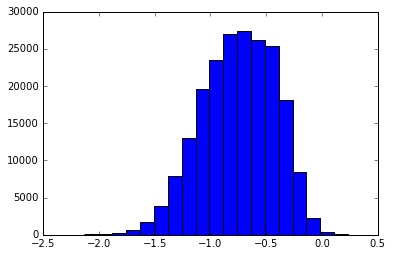

In [36]:
plt.hist(score[~np.isnan(score)], bins=20);

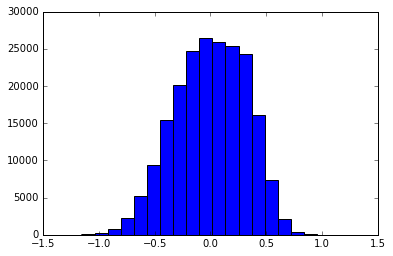

In [37]:
plt.hist(score_centred[~np.isnan(score_centred)], bins=20);

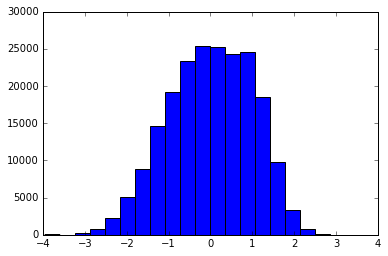

In [38]:
plt.hist(score_normed[~np.isnan(score_normed)], bins=20);

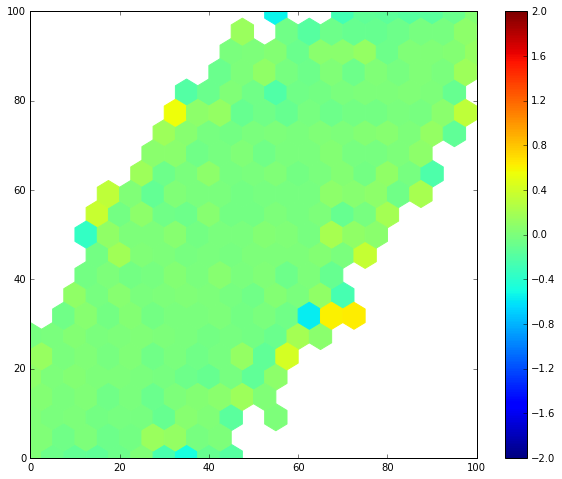

In [39]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
C = score_centred
plt.figure(figsize=(10, 8))
plt.hexbin(x, y, C, gridsize=20, vmin=-2, vmax=2)
plt.colorbar();

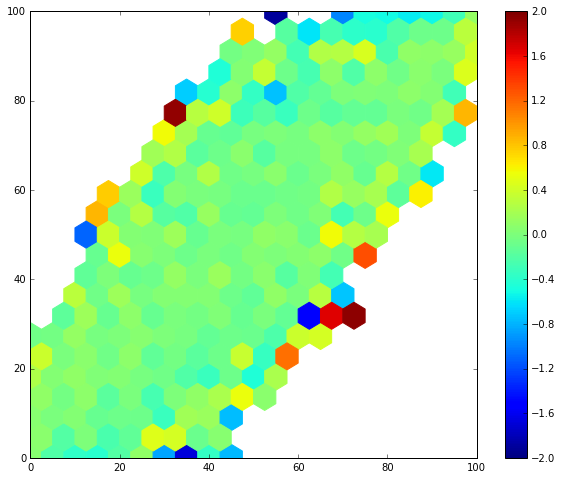

In [40]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
C = score_normed
plt.figure(figsize=(10, 8))
plt.hexbin(x, y, C, gridsize=20, vmin=-2, vmax=2)
plt.colorbar();

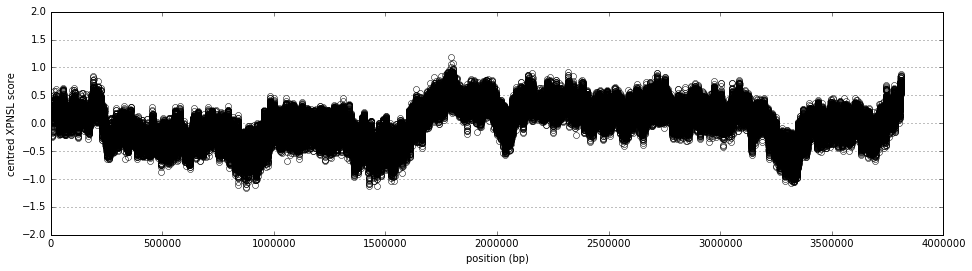

In [41]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score_centred, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('centred XPNSL score')
plt.ylim(-2, 2);

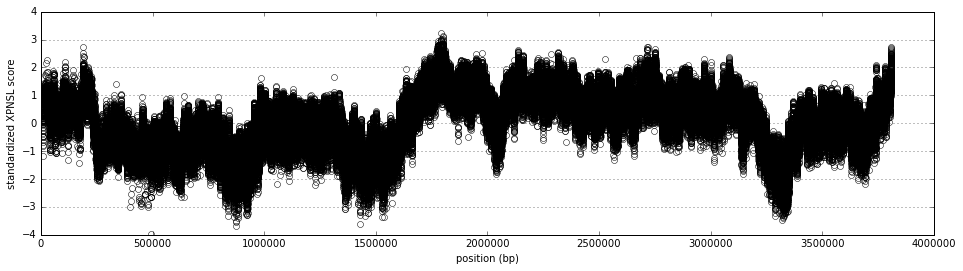

In [42]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score_normed, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('standardized XPNSL score');

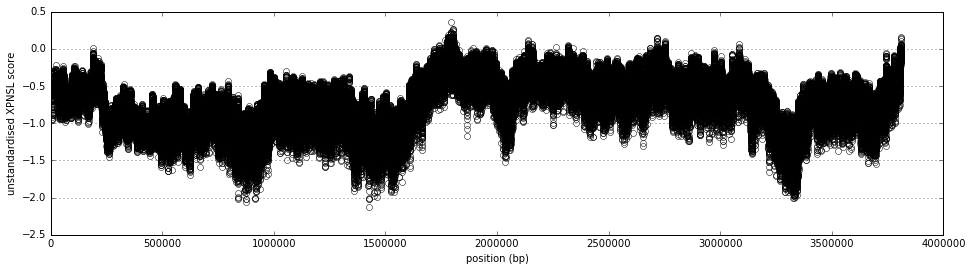

In [43]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised XPNSL score');

In [13]:
cProfile.run('allel.stats.xpnsl(h1_seg, h2_seg, use_threads=False)', sort='time')

         122 function calls in 5.759 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    5.746    1.437    5.746    1.437 stats.pyx:576(nsl_scan_int8)
        1    0.012    0.012    5.759    5.759 selection.py:480(xpnsl)
        8    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.array}
        1    0.000    0.000    5.759    5.759 <string>:1(<module>)
        1    0.000    0.000    5.759    5.759 {built-in method builtins.exec}
       16    0.000    0.000    0.000    0.000 stringsource:341(__cinit__)
        4    0.000    0.000    0.000    0.000 stringsource:985(memoryview_fromslice)
        4    0.000    0.000    5.746    1.437 {allel.opt.stats.nsl_scan_int8}
        6    0.000    0.000    0.000    0.000 numeric.py:414(asarray)
        2    0.000    0.000    0.000    0.000 ndarray.py:1810(__getitem__)
        2    0.000    0.000    0.000    0.000 ndarray.py:1776(__new__)
        4    0.00

In [64]:
xpehh_min0 = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.0, include_edges=True)

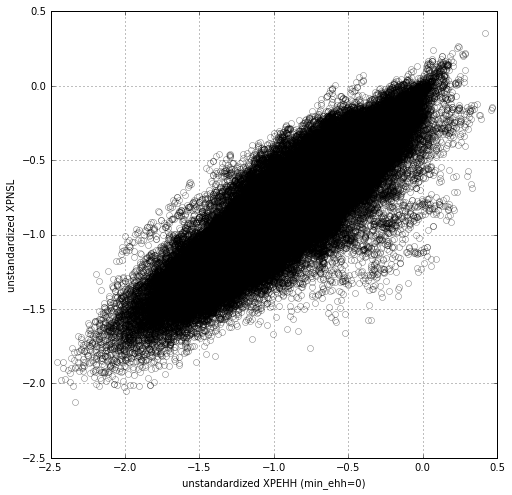

In [65]:
plt.figure(figsize=(8, 8))
plt.plot(xpehh_min0, score, marker='o', linestyle=' ', mfc='none', alpha=.5)
plt.xlabel('unstandardized XPEHH (min_ehh=0)')
plt.ylabel('unstandardized XPNSL')
plt.grid(axis='both');

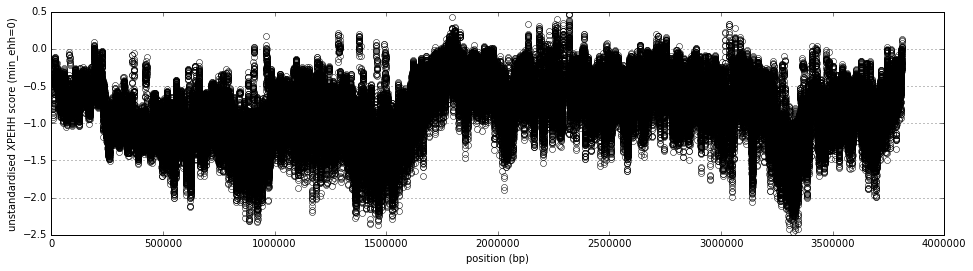

In [66]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, xpehh_min0, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised XPEHH score (min_ehh=0)');

In [67]:
xpehh = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, include_edges=True)

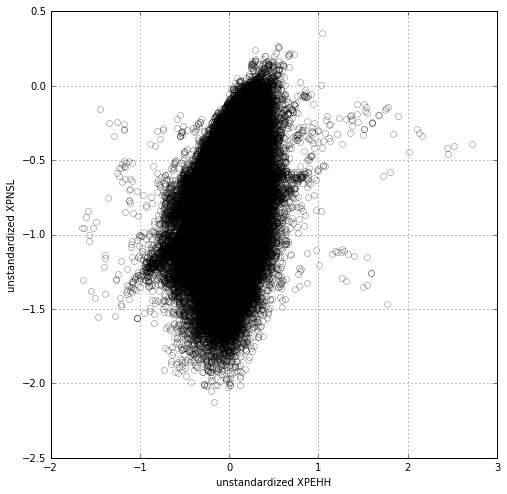

In [68]:
plt.figure(figsize=(8, 8))
plt.plot(xpehh, score, marker='o', linestyle=' ', mfc='none', alpha=.5)
plt.xlabel('unstandardized XPEHH')
plt.ylabel('unstandardized XPNSL')
plt.grid(axis='both');

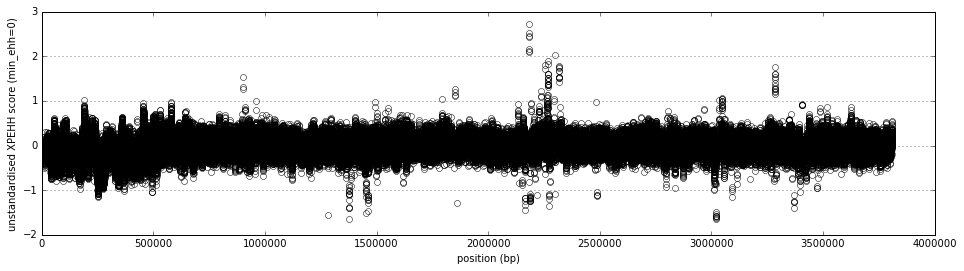

In [69]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, xpehh, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised XPEHH score (min_ehh=0)');